# PyOracle query/match function test

In [1]:
%load_ext autoreload
%autoreload 2
import factoracle as fa
import Resources.analysis as an
import Resources.generate as ge
import Resources.helpers as helpers
import numpy as np
import matplotlib.pyplot as plt
from bregman.suite import Chromagram

%matplotlib inline


ImportError: No module named factoracle

## Load wavfile and plot chroma

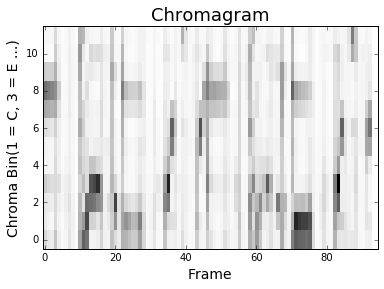

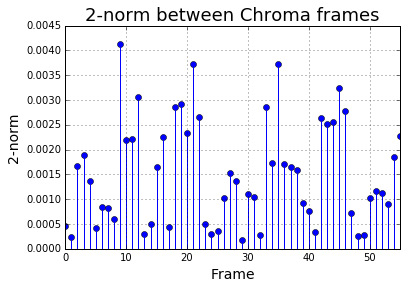

In [10]:
targetfile = 'FunkBass.wav' #prokofiev 'hmmtesttone.wav'
# targetfile = 'hmmtesttone.wav'
qfilename = 'audio_query_test.wav'
sfilename = 'audio_shuffled_test.wav'


fft_size = 8192
hop_size = fft_size/2
chroma = Chromagram(targetfile, log10=True, intensify=True, nfft=fft_size, wfft=fft_size, nhop=hop_size)

plt.figure()
plt.imshow(chroma.X, aspect = 'auto', origin = 'lower', interpolation = 'nearest', cmap ='Greys')
plt.title('Chromagram', fontsize = 18)
plt.xlabel('Frame', fontsize = 14)
plt.ylabel('Chroma Bin(1 = C, 3 = E ...)', fontsize = 14)

plt.figure()
plt.stem(np.sqrt(np.sum(np.diff(chroma.X)**2,0)))
plt.grid(b = 'on')
plt.xlim((0, 55))
plt.title('2-norm between Chroma frames', fontsize = 18)
plt.xlabel('Frame', fontsize = 14)
plt.ylabel('2-norm', fontsize = 14)


## Calculate ideal threhold via IR

testing threshold: 0.0
testing threshold: 1e-05
testing threshold: 2e-05
testing threshold: 3e-05
testing threshold: 4e-05
testing threshold: 5e-05
testing threshold: 6e-05
testing threshold: 7e-05
testing threshold: 8e-05
testing threshold: 9e-05
testing threshold: 0.0001
testing threshold: 0.00011
testing threshold: 0.00012
testing threshold: 0.00013
testing threshold: 0.00014
testing threshold: 0.00015
testing threshold: 0.00016
testing threshold: 0.00017
testing threshold: 0.00018
testing threshold: 0.00019
testing threshold: 0.0002
testing threshold: 0.00021
testing threshold: 0.00022
testing threshold: 0.00023
testing threshold: 0.00024
testing threshold: 0.00025
testing threshold: 0.00026
testing threshold: 0.00027
testing threshold: 0.00028
testing threshold: 0.00029
testing threshold: 0.0003
testing threshold: 0.00031
testing threshold: 0.00032
testing threshold: 0.00033
testing threshold: 0.00034
testing threshold: 0.00035
testing threshold: 0.00036
testing threshold: 0.00037

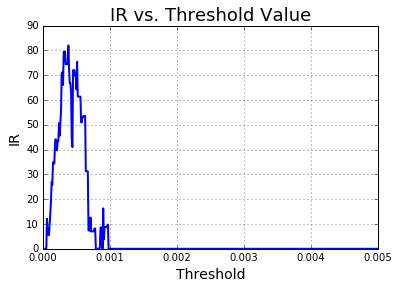

In [11]:
features = {}
frames_per = 1
chroma_frames = [[0]] * len(chroma.X[0])
for i, frame in enumerate(chroma.X[0]):
    chroma_frames[i] = [component[i] for component in chroma.X]
features['chroma'] = chroma_frames

r = (0.0000, 0.002, 0.00001) 
#ideal_t = fa.calculate_ideal_threshold(r, features, 'chroma', frames_per_state=frames_per, ir_type='cum', VERBOSE = False)
ideal_t = fa.calculate_ideal_threshold(r, features, 'chroma', frames_per_state=frames_per, ir_type='cum')
x_a = [i[1] for i in ideal_t[1]]
y_a = [i[0] for i in ideal_t[1]]
plt.figure()
plt.plot(x_a, y_a, linewidth = 2)
plt.title('IR vs. Threshold Value', fontsize = 18)
plt.grid(b = 'on')
plt.xlabel('Threshold', fontsize = 14)
plt.ylabel('IR', fontsize = 14)


## Construct target Audio Oracle

In [ ]:
t_oracle = fa.make_oracle(ideal_t[0][1], 'a', features, 'chroma', frames_per_state=frames_per)

In [20]:
img = fa.draw_oracle(t_oracle, 'boutput.png', size=(1200, 400))
print img

None


TypeError: Image data can not convert to float

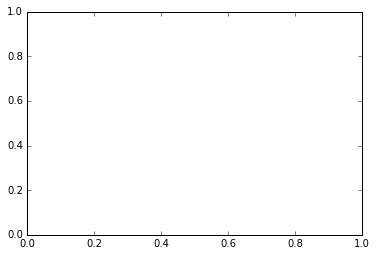

In [15]:
plt.figure()
f = plt.gca()
plt.imshow(np.asarray(img), aspect = 'auto')
f.axes.xaxis.set_ticklabels([])
f.axes.yaxis.set_ticklabels([])
plt.title('Oracle Structure', fontsize = 18)

## Test with querying itself - perfect reconstruction expected

In [83]:
query_events = helpers.features_to_events(features)
path_1, cost_1, i_hat_1 = an.query_complete(t_oracle, query_events, method = 'complete')
print '================='
print 'Query with itself'
print '================='
print 'Perfect reconstruction:'
if path_1[i_hat_1] == range(1,t_oracle.n_states):
    print 'Passed with cost '+ str(cost_1[i_hat_1]) 
else:
    print 'Failed with cost '+ str(cost_1[i_hat_1])

Query with itself
Perfect reconstruction:
Passed with cost 0.0


## Test with shuffled version

By current query/matching strategy, the query is sub optimal in the sense that it only considers forward links and the current state as possible next state, but the shuffled sequence generated by PyOracle could have the next state the forward states along the suffix links. I.e, for state k, the query function considers {trn[k],k} as possible next state while the generate function in PyOracle considers trn[sfx[k]] as possible next state as well. 

In [84]:
s, _kend, _ktrace = ge.generate(t_oracle, 
                                20, 
                                0.1, 
                                0, LRS = 1, 
                                weight='weight')
query = {}
query_features = [chroma_frames[_s-1] for _s in s]
query['chroma'] = query_features

query_events2 = []
keys = query.keys()
num_events = len(query[keys[0]])
for i in range(num_events):
    new_event = {}
    for key in keys:
        new_event[key] = query[key][i]
    query_events2.append(new_event)    

path, cost, i_hat = an.query_complete(t_oracle, query_events2, method = 'complete')

print '============================'
print 'Query with shuffled original'
print '============================'
print 'Perfect reconstruction:'
if path[i_hat] == s:
    print 'Passed with cost '+ str(cost[i_hat]) 
else:
    print 'Failed with cost '+ str(cost[i_hat])
print 'Retrieved path: ', path[i_hat] 
print 'Shuffled path:  ', s

Query with shuffled original
Perfect reconstruction:
Passed with cost 0.0
Retrieved path:  [1, 2, 4, 5, 6, 7, 80, 81, 82, 8, 81, 82, 71, 72, 73, 75, 76, 76, 77, 54]
Shuffled path:   [1, 2, 4, 5, 6, 7, 80, 81, 82, 8, 81, 82, 71, 72, 73, 75, 76, 76, 77, 54]


In [82]:
ge.audio_synthesis(targetfile, qfilename, path[i_hat], fft_size, hop_size)
ge.audio_synthesis(targetfile, sfilename, s, fft_size, hop_size)

(array([ 0.,  3.,  8., ...,  0.,  0.,  0.]),
 array([  1.00000000e-05,   1.01471045e-05,   1.05884178e-05, ...,
          1.05884178e-05,   1.01471045e-05,   1.00000000e-05]))